In [6]:
# Coinbase Sandbox Demo
#
# this demo uses the Coinbase Pro client for Python: 
# https://github.com/danpaquin/coinbasepro-python
#
# it's recommended to run cbpro in its own Python environment:
# conda create --name environment_name
#
# pip install cbpro
# or
# pip install git+git://github.com/danpaquin/coinbasepro-python.git
#
# there are a number of libraries that need to be in the python environment for this demo
# to run.  please review the import statements below and install the necessary dependencies
# before running this notebook.

import os

import cbpro

import json, hmac, hashlib, time, requests, base64
from requests.auth import AuthBase

import time
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

# the Coinbase Pro Sandbox api key, secret, and passphrase have been stored locally as environment variables.
# in order to implement this project, setup a Coinbase Pro account and generate a Coinbase Pro Sandbox
# api key.  For more information go to the Coinbase Pro Sandbox Documentation url below--
# https://docs.pro.coinbase.com/#sandbox

# get current directory
__file__ = 'coinbaseSandbox.ipynb'

dir_path = os.path.dirname(os.path.realpath(__file__))

#print('directory path: ', dir_path)

# Authentication credentials
api_key = os.environ.get('coinbaseSandboxKey')
api_secret = os.environ.get('coinbaseSandboxSecret')
passphrase = os.environ.get('coinbaseSandboxPassphrase')

# sandbox authenticated client
auth_client = cbpro.AuthenticatedClient(api_key, api_secret, passphrase, \
                                        api_url='https://api-public.sandbox.pro.coinbase.com')
# live account authenticated client
# uses a different set of API access credentials (api_key, api_secret, passphrase)
# auth_client = cbpro.AuthenticatedCliet(api_key, api_secret, passphrase)

# get accounts listed for api key
account_info = auth_client.get_accounts()

df = pd.DataFrame(account_info)

df.to_csv('account_info.csv') # save data locally for development use

directory path:  C:\Users\wojnj1\Documents\+coinbase


In [5]:
# get list of products

import cbpro

import pandas as pd

import json, hmac, hashlib, time, requests, base64
from requests.auth import AuthBase

# Define Public Client
public_client = cbpro.PublicClient()

# Get Products
products = pd.DataFrame(public_client.get_products())

products.sort_values('max_market_funds')

print(products[:10])

products.to_csv('products.csv')

         id base_currency quote_currency base_min_size    base_max_size  \
0   DAI-USD           DAI            USD    1.00000000  100000.00000000   
1   BAL-BTC           BAL            BTC    0.10000000    6700.00000000   
2  AAVE-USD          AAVE            USD    0.01000000    1200.00000000   
3   SNX-EUR           SNX            EUR    0.10000000   19000.00000000   
4   LTC-USD           LTC            USD    0.10000000    4000.00000000   
5   XTZ-EUR           XTZ            EUR    1.00000000  100000.00000000   
6   XTZ-USD           XTZ            USD    1.00000000  100000.00000000   
7  BAT-USDC           BAT           USDC    1.00000000  800000.00000000   
8   XRP-EUR           XRP            EUR    1.00000000  500000.00000000   
9   ETC-EUR           ETC            EUR    0.10000000   20000.00000000   

  quote_increment base_increment display_name min_market_funds  \
0      0.00000100     0.00001000      DAI/USD                5   
1      0.00000001     0.01000000      BAL/

In [7]:
# Get Historic Rates
# the max number of data points for a single request is 300 candles
# if start/end time and granularity results in more than 300 data points,
# the request will be rejected.
# Make multiple requests if fine granularity results in > 300 data points.

import cbpro

import json, hmac, hashlib, time, requests, base64
from requests.auth import AuthBase

# Define Public Client
public_client = cbpro.PublicClient()

# Define ticker symbol to retrieve
symbol = 'BTC-USD'

# Issue: start and end dates results in error
# Default returns 300 data points at specified granularity
# Optional parameters: start and end dates need to be in ISO 8601 format (YYYYMMDD)
#start = 20201215
#end = 20201231

# granularity is the time between ticks and must be one of these values:
# {60, 300, 900, 3600, 21600, 86400} which corresponds to
# one minute (60 sec), five minutes (300 sec), fifteen minutes (900 sec),
# one hour (3600 sec), six hours (21600 sec), and one day (86400 sec)

granularity = 86400

try:
    tick_data = pd.DataFrame(public_client.get_product_historic_rates(symbol, granularity=granularity))
except: print("Request is invalid: verify start-end dates and granularity results in less than 300 data points")

tick_data.rename(columns={0:'time', 1:'low', 2:'high', 3:'open', 4:'close', 5:'volume'}, inplace=True)

tick_data.to_csv('BTC-USD.csv')

In [13]:
# work with saved historic data to minimize the number of api requests

import pandas as pd

tick_data = pd.read_csv('BTC-USD.csv', index_col=0, infer_datetime_format=True, parse_dates=True)

tick_data.iloc[:, 0] = pd.to_datetime(tick_data.iloc[:, 0], infer_datetime_format=True, unit='s')

tick_data.set_index('time', inplace=True)

tick_data.sort_values(by='time', inplace=True)

data = tick_data

data.head

<bound method NDFrame.head of                  low      high      open     close         volume
time                                                             
2020-03-08   8002.20   8901.37   8901.36   8037.76   16591.914102
2020-03-09   7630.00   8187.03   8037.73   7934.52   25563.614175
2020-03-10   7733.56   8158.25   7934.56   7894.68   17172.471301
2020-03-11   7583.27   7987.97   7894.68   7938.05   13647.865139
2020-03-12   4644.00   7969.45   7938.05   4857.10  113902.203329
...              ...       ...       ...       ...            ...
2020-12-28  26086.19  27477.00  26255.16  27040.36   21265.709350
2020-12-29  25833.73  27396.77  27039.39  27366.35   20668.104338
2020-12-30  27311.73  29018.26  27366.35  28897.42   28181.496815
2020-12-31  28000.00  29321.90  28897.42  28990.08   28813.886911
2021-01-01  28751.82  29083.75  28990.08  29039.66    1204.307665

[300 rows x 5 columns]>

In [14]:
# Create the features data by lagging the log returns

# Adapted from Python For Finance, 2nd ed., Hilpisch, Yves.
# Chapter 16 - Automated Trading, ML-Based Trading Strategy: Vectorized Backtesting

import numpy as np
import pandas as pd

data['mid'] = (data['high']+data['low'])/2

data['returns'] = np.log(data['mid']/data['mid'].shift(1))

lags = 5

def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)

create_lags(data)

data.dropna(inplace=True)

data[cols] = np.where(data[cols] > 0, 1, 0)

data['direction'] = np.where(data['returns'] > 0, 1, -1)

data[cols + ['direction']].head

<bound method NDFrame.head of             lag_1  lag_2  lag_3  lag_4  lag_5  direction
time                                                    
2020-03-14    0.0    0.0    0.0    1.0    0.0          1
2020-03-15    1.0    0.0    0.0    0.0    1.0          1
2020-03-16    1.0    1.0    0.0    0.0    0.0         -1
2020-03-17    0.0    1.0    1.0    0.0    0.0          1
2020-03-18    1.0    0.0    1.0    1.0    0.0         -1
...           ...    ...    ...    ...    ...        ...
2020-12-28    1.0    1.0    1.0    0.0    1.0         -1
2020-12-29    0.0    1.0    1.0    1.0    0.0         -1
2020-12-30    0.0    0.0    1.0    1.0    1.0          1
2020-12-31    1.0    0.0    0.0    1.0    1.0          1
2021-01-01    1.0    1.0    0.0    0.0    1.0          1

[294 rows x 6 columns]>

In [18]:
# A support vector machine algorithm for classification is used.
# The code trains and tests the algorithmic trading strategy based on a sequential train-test split.

# Adapted from Python For Finance, 2nd ed., Hilpisch, Yves.
# Chapter 16 - Automated Trading, ML-Based Trading Strategy: Vectorized Backtesting

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

model = SVC(C=1, kernel='linear', gamma = 'auto')

split = int(len(data) * 0.80)

train = data.iloc[:split].copy() # training dataset

model.fit(train[cols], train['direction'])

accuracy_score(train['direction'], model.predict(train[cols]))

0.5872340425531914

In [19]:
test = data.iloc[split:].copy()  # test dataset

test['position'] = model.predict(test[cols])

accuracy_score(test['direction'], test['position'])

0.6779661016949152

In [21]:
# Backtesting with Proportional Transaction Costs (ptc)

# Coinbase uses a maker-taker fee model.  However, for amounts < $10k the maker-taker fee is 0.50%
# The maker-taker fee model uses a pricing tier model where larger transaction volumes, in USD,
# are charged a lower percentage: 
#                                  < $10k   0.50%  (taker = maker)
#                            $50M - $100M   0.10% (taker) 0.00% (maker)

# https://help.coinbase.com/en/pro/trading-and-funding/trading-rules-and-fees/fees.html

ptc = 0.005  # 0.50%

test['strategy'] = test['position'] * test['returns']

sum(test['position'].diff() !=0)

1

In [22]:
test['strategy_tc'] = np.where(test['position'].diff() != 0,
                              test['strategy'] - ptc,
                              test['strategy'])

test[['returns', 'strategy', 'strategy_tc']].sum().apply(np.exp)

returns        2.112989
strategy       2.112989
strategy_tc    2.102450
dtype: float64

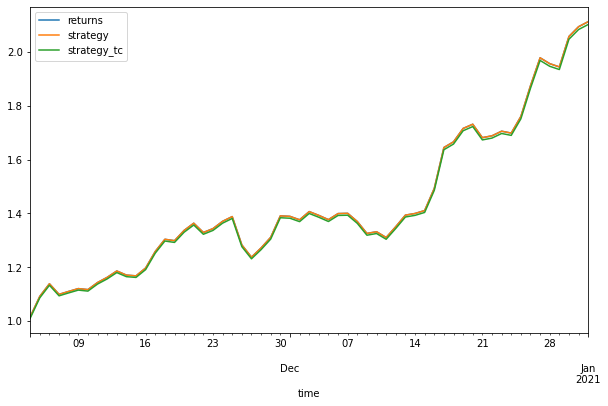

In [24]:
# plot results

from pylab import mpl, plt

test[['returns', 'strategy', 'strategy_tc']].cumsum().apply(np.exp).plot(figsize=(10,6))
plt.savefig('10-BTC-USD_SVM.png')
plt.show()